In [1]:
import math, os
import numpy as np
import pickle
from scipy import constants
from astropy.io import fits
from POSEIDON.constants import R_Sun, R_J, M_J
import numpy as np
from spectres import spectres
from datetime import datetime
from matplotlib.pyplot import *
import time
from matplotlib.pyplot import cm
from array import *
from astropy.io import fits
import glob
from matplotlib import rcParams
import colormaps as cmaps
import matplotlib.pyplot as plt
import h5py

params = {
    "legend.fontsize": 25,
    "axes.labelsize": 30,
    "axes.titlesize": 25,
    "xtick.labelsize": 25,
    "ytick.labelsize": 25,
}
rcParams["font.family"] = "sans-serif"
rcParams.update(params)

# TODO:
### 1. Migrate plotting function into high res
### 2. Make tutorials

In [2]:
def get_coordinate_list(x_values, y_values):
    x, y = np.meshgrid(x_values, y_values)
    coordinates = np.dstack([x, y]).reshape(-1, 2)
    return [tuple(coord) for coord in coordinates]

In [3]:
loglikelihoods = []
CCFs = []
CCF_per_phases = []
data_path = "./data/WASP-121b/"
data_path = "./data/WASP-121b-injection-a10/"
data_path = "./data/WASP-77Ab-injection-6/"
output_path = "./CC_output/WASP-121b/"
# output_path = "./CC_output/WASP-121b-injection-a10/"
# output_path = "./CC_output/WASP-77Ab-injection-6/"
# output_path = f"./CC_output/WASP-76b-MAROON/night_{n}/"
# output_path = f"./CC_output/WASP-76b/"
# name = "WASP-77Ab"
name = "WASP-121b"
# name = f"WASP-76b-MAROON-{n}"
# name = f"WASP-76b"
data = h5py.File("./data/WASP-121.h5", "r")
for key in data.keys():
    # Kp_arr, Vsys_arr, RV_range, loglikelihood, CCF, CCF_per_phase = pickle.load(
    #     open(output_path + "H2O_cross_correlation_results.pic", "rb")
    # )

    Kp_arr, Vsys_arr, RV_range, loglikelihood, CCF, CCF_per_phase = (
        data[key]["Kp_arr"][:],
        data[key]["Vsys_arr"][:],
        data[key]["RV_range"][:],
        data[key]["loglikelihood_map"][:],
        data[key]["CCF_map"][:],
        data[key]["CCF_per_phase"][:],
    )

    loglikelihoods.append(loglikelihood)
    CCFs.append(CCF)

loglikelihood = np.sum(loglikelihoods, axis=0)
CCF = np.sum(CCFs, axis=0)

K_p = -200
V_sys = 10  # True value

stdev_range_x = np.where((Kp_arr < K_p - 15) | (Kp_arr > K_p + 15))[0]
stdev_range_y = np.where((Vsys_arr < V_sys - 15) | (Vsys_arr > V_sys + 15))[0]
stdev_range = get_coordinate_list(stdev_range_x, stdev_range_y)

loglikelihood = loglikelihood - np.mean(loglikelihood)
stdev = np.std(loglikelihood[stdev_range])
maxx = (loglikelihood / stdev).max()
print(maxx)
loc = np.where(loglikelihood / stdev == maxx)


fig, ax = subplots()
cax = ax.imshow(
    loglikelihood / stdev,
    extent=[Vsys_arr.min(), Vsys_arr.max(), Kp_arr.min(), Kp_arr.max()],
    aspect="auto",
    # interpolation="bilinear",
    origin="lower",
)

cbar = colorbar(cax)
axvline(x=V_sys, color="white", ls="--", lw=2)
axhline(y=K_p, color="white", ls="--", lw=2)
plot(Vsys_arr[loc[1]], Kp_arr[loc[0]], "xk", ms=7)
axis([Vsys_arr.min(), Vsys_arr.max(), Kp_arr.min(), Kp_arr.max()])
xlabel("$\Delta$V$_{sys}$ [km/s]")
ylabel("K$_{p}$ [km/s]")
title("$\Delta $log$L$")

now = datetime.now()  # current date and time
date_time = now.strftime("%m_%d_%H_%M")

savefig(output_path + name + "_logL_SNR" + str(date_time) + ".pdf", fmt="pdf")
show()
close()

# CCF
CCF = CCF - np.mean(CCF)
stdev = np.std(CCF[stdev_range])
maxx = (CCF / stdev).max()
print(maxx)
loc = np.where(CCF / stdev == maxx)
fig, ax = subplots()
cax = ax.imshow(
    CCF / stdev,
    extent=[Vsys_arr.min(), Vsys_arr.max(), Kp_arr.min(), Kp_arr.max()],
    aspect="auto",
    # interpolation="bilinear",
    # cmap="cividis",
    cmap=cmaps.cividis,
    origin="lower",
)
cbar = colorbar(cax)
axvline(x=V_sys, color="white", ls="--", lw=2)
axhline(y=K_p, color="white", ls="--", lw=2)
plot(Vsys_arr[loc[1]], Kp_arr[loc[0]], "xk", ms=7)
axis([Vsys_arr.min(), Vsys_arr.max(), Kp_arr.min(), Kp_arr.max()])
xlabel("$\Delta$V$_{sys}$ [km/s]")
ylabel("K$_{p}$ [km/s]")
title("$\Delta CCF (\sigma)$")
savefig(output_path + name + "_CCF_SNR" + str(date_time) + ".pdf", fmt="pdf")
show()
close()


# slice at Kp
index = np.argmin(np.abs(Kp_arr - Kp_arr[loc[0]]))
slicee = CCF[index]
plot(Vsys_arr, slicee)
axis([-200, 200, 1.1 * slicee.min(), 1.1 * slicee.max()])
xlabel("$\Delta$V$_{sys}$ [km/s]")
ylabel("$\Delta$CCF")
axvline(x=V_sys, ls="--", color="black")
subplots_adjust(left=0.1, right=0.9, top=0.7, bottom=0.3)
savefig(output_path + name + "_CCF_slice.pdf", fmt="pdf")
show()
close()

KeyError: "Unable to open object (object 'Kp_arr' doesn't exist)"

In [74]:
# CCF_per_phase
from POSEIDON.utility import read_high_res_data

phi = read_high_res_data(data_path, method="pca", spectrum_type="emission")["phi"]
# phi = read_high_res_data(data_path")["phi"]
RV_min = min(
    [
        np.min(Kp_arr * np.sin(2 * np.pi * phi[i])) + np.min(Vsys_arr)
        for i in range(len(phi))
    ]
)
RV_max = max(
    [
        np.max(Kp_arr * np.sin(2 * np.pi * phi[i])) + np.max(Vsys_arr)
        for i in range(len(phi))
    ]
)

RV_range = np.arange(RV_min, RV_max + 1)

In [75]:
# # for 121 injection
# for i in range(len(CCF_per_phase)):
#     CCF_per_phase[i] = CCF_per_phase[i] - np.mean(CCF_per_phase[i])
#     stdev = np.std(CCF_per_phase[i])
#     CCF_per_phase[i] = CCF_per_phase[i] / stdev
# maxx = (CCF_per_phase).max()
# print(maxx)
# loc = np.where(CCF_per_phase / stdev == maxx)
# fig, ax = subplots()
# cax = ax.imshow(
#     CCF_per_phase,
#     extent=[RV_range.min(), RV_range.max(), phi.min(), phi.max()],
#     aspect="auto",
#     # interpolation="bilinear",
#     # cmap="cividis",
#     cmap=cmaps.cividis,
#     origin="lower",
# )


# cbar = colorbar(cax)
# axvline(x=V_sys, color="white", ls="--", lw=2)
# axhline(y=0, color="white", ls="--", lw=2)
# plt.plot(
#     np.arange(-100, 50),
#     (np.arange(-100, 50) + 20) / (-200) / (2 * np.pi),
#     "--",
#     color="red",
#     alpha=0.5,
# )
# # plot(Vsys_arr[loc[1]], phi[loc[0]], "xk", ms=7)
# # axis([Vsys_arr.min(), Vsys_arr.max(), phi.min(), phi.max()])
# xlabel("Planet Velocity [km/s]")
# ylabel("Phase")
# title("$\Delta CCF (\sigma)$")
# show()
# close()

3.733149682400475


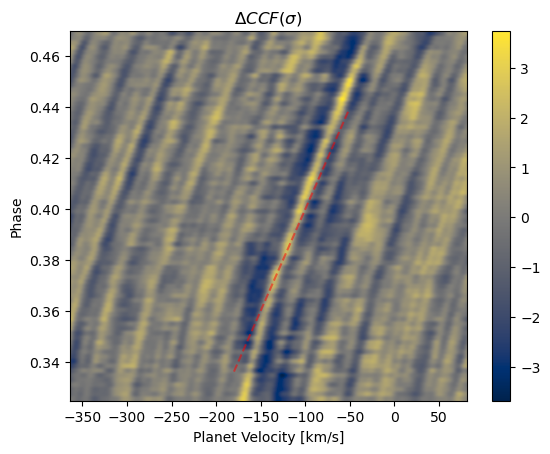

In [76]:
# for 77 injection
for i in range(len(CCF_per_phase)):
    CCF_per_phase[i] = CCF_per_phase[i] - np.mean(CCF_per_phase[i])
    stdev = np.std(CCF_per_phase[i])
    CCF_per_phase[i] = CCF_per_phase[i] / stdev
maxx = (CCF_per_phase).max()
print(maxx)
loc = np.where(CCF_per_phase / stdev == maxx)
fig, ax = subplots()
cax = ax.imshow(
    CCF_per_phase,
    extent=[RV_range.min(), RV_range.max(), phi.min(), phi.max()],
    aspect="auto",
    # interpolation="bilinear",
    # cmap="cividis",
    cmap=cmaps.cividis,
    origin="lower",
)


cbar = colorbar(cax)
# axvline(x=V_sys, color="white", ls="--", lw=2)
# axhline(y=phi[len(phi) // 2], color="white", ls="--", lw=2)
plt.plot(
    np.arange(-180, -50),
    (np.arange(-180, -50) + 100) / (200) / (2 * np.pi)
    + 0.4,  # phi start from 90 degrees. sin(phi-90) -90 = -phi
    "--",
    color="red",
    alpha=0.5,
)
# plot(Vsys_arr[loc[1]], phi[loc[0]], "xk", ms=7)
# axis([Vsys_arr.min(), Vsys_arr.max(), phi.min(), phi.max()])
xlabel("Planet Velocity [km/s]")
ylabel("Phase")
title("$\Delta CCF (\sigma)$")
show()
close()